<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/papers/Artigo%201/V4/Vers%C3%A3o_4_(sem_balanceamento).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine learning for predicting liver and/or lung metastasis in colorectal cancer: A retrospective study based on the SEER database***

Este estudo propõe um modelo de aprendizado de máquina para prever o risco de metástase hepática e/ou pulmonar em pacientes com câncer colorretal (CRC). A partir da base de dados SEER, foram extraídos dados aproximadamente 53 mil pacientes com diagnóstico patológico de CRC entre 2010 e 2015, desenvolvendo sete modelos de algoritmos(Decision tree, Randon Forest, Naive Bayes,  KNN,XGBoost, Gradient Boosting.

### Parte 1:  Importação das Bibliotecas e Carregamento do Dataset

Nesta etapa, importamos as bibliotecas necessárias para análise e carregamos o dataset. Realizamos uma verificação inicial para identificar e remover valores faltantes e definimos as variáveis preditoras (X) e as variáveis alvo (y), preparando os dados para o pré-processamento e a modelagem.

In [1]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')
df.dropna(inplace=True)

# Definir as variáveis preditoras e a variável alvo
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis']]

y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

y = pd.concat([y_liver, y_lung], axis=1)

###Parte 2:  Preparação das Variáveis Alvo e Codificação de Variáveis Categóricas

Nesta etapa, preparamos as variáveis alvo (y), combinando as informações de metástase hepática e pulmonar em uma coluna binária para indicar a presença de metástase. Também aplicamos LabelEncoder para transformar variáveis categóricas de X em valores numéricos, facilitando o uso dos dados em modelos de aprendizado de máquina.

In [2]:
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Tamanho de X: 53448
Tamanho de y: 53448


###Parte 3: Definição e Configuração dos Modelos de Aprendizado de Máquina e Validação Cruzada

Aqui, configuramos os principais algoritmos de aprendizado de máquina, incluindo Decision Tree, Random Forest, SVM, Naive Bayes, KNN, XGBoost e Gradient Boosting. Cada modelo é definido com parâmetros específicos para otimizar o desempenho. Em seguida, aplicamos uma validação cruzada estratificada com 5 divisões para avaliar e comparar a performance dos modelos de maneira consistente e robusta.

In [3]:
# Definição dos modelos de aprendizado de máquina com hiperparâmetros ajustados
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ),
    "SVM": SVC(
        kernel='poly',
        gamma='scale',
        degree=3,
        C=10,
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(
        leaf_size=20,
        metric='manhattan',
        n_neighbors=11,
        weights='uniform'
    ),
    "XGBoost": XGBClassifier(
        colsample_bytree=0.6,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=10.0,
        subsample=1.0,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=3,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    )
}

# Lista de técnicas de balanceamento
#smote_techniques = {
#    "SMOTE": SMOTE(random_state=42),
#}

# Configuração da validação cruzada estratificada com 5 divisões (folds)
# Isso garante que a proporção de classes seja mantida em cada divisão, e o shuffle embaralha os dados antes de dividir
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Parte 4: Avaliação e Comparação dos Modelos de Aprendizado de Máquina em Conjuntos de Treino, Validação e Teste


Este bloco de código implementa a validação cruzada para treinar e avaliar os modelos de aprendizado de máquina definidos no pipeline. Ele utiliza a técnica de K-Fold Cross-Validation para dividir os dados em múltiplos folds, garantindo uma avaliação robusta do desempenho dos modelos. Durante cada fold, os dados de treinamento são balanceados utilizando o SMOTE e escalados com o StandardScaler. Métricas de desempenho, como precisão, recall, F1-Score, especificidade, AUC-ROC e AUPR, são calculadas tanto para o conjunto de treinamento quanto para o conjunto de teste. Além disso, visualizações como matrizes de confusão e curvas ROC e Precisão-Recall são geradas. Ao final, as métricas médias de todos os folds são compiladas para comparação.


Aplicando Decision Tree sem balanceamento

Aplicando Random Forest sem balanceamento

Aplicando SVM sem balanceamento

Aplicando Naive Bayes sem balanceamento

Aplicando KNN sem balanceamento

Aplicando XGBoost sem balanceamento

Aplicando Gradient Boosting sem balanceamento


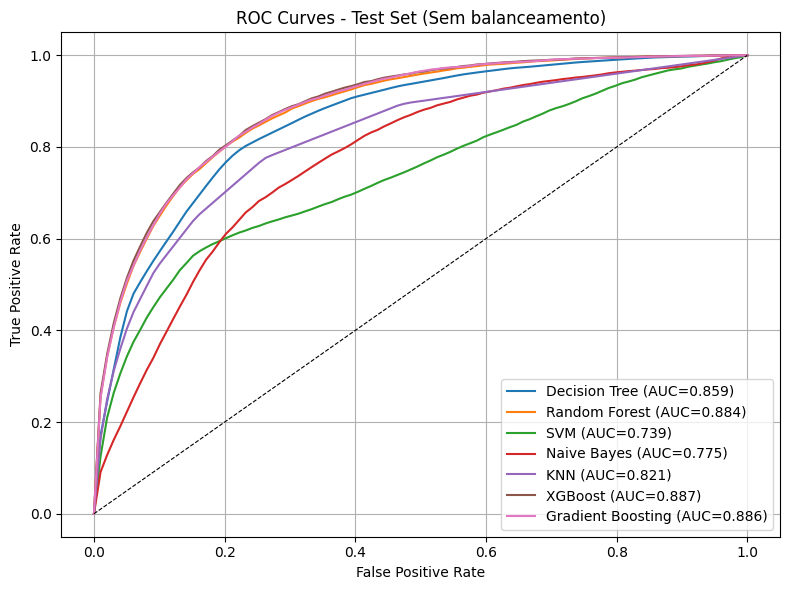

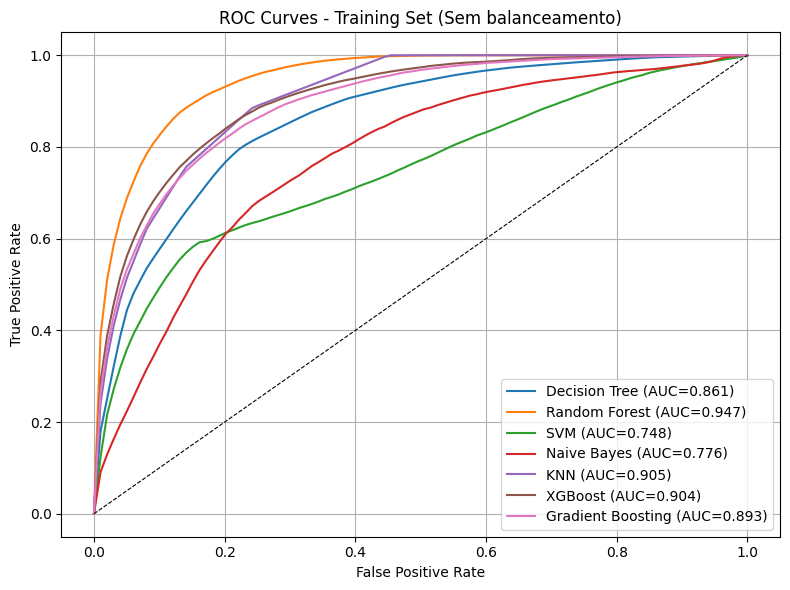


Resultados - Teste (Sem balanceamento):
               Model  Accuracy       AUC  Precision  Recall rate  F1-score
0      Decision Tree  0.875281  0.859003   0.614977     0.418413  0.497714
1      Random Forest  0.886450  0.883567   0.726543     0.372627  0.492548
2                SVM  0.858853  0.738548   0.667946     0.091070  0.160228
3        Naive Bayes  0.820611  0.774924   0.388279     0.368454  0.377995
4                KNN  0.872549  0.821238   0.635909     0.324310  0.429435
5            XGBoost  0.887330  0.887485   0.704446     0.410825  0.518848
6  Gradient Boosting  0.886244  0.885682   0.690497     0.418668  0.521244

Resultados - Treinamento (Sem balanceamento):
               Model  Accuracy       AUC  Precision  Recall rate  F1-score
0      Decision Tree  0.875346  0.860718   0.616146     0.418037  0.497929
1      Random Forest  0.907204  0.946785   0.842407     0.458418  0.593716
2                SVM  0.859092  0.748473   0.674797     0.091291  0.160759
3        Nai

In [6]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dicionários para curvas ROC e tabelas de resultados
roc_curves_test = {}
roc_curves_train = {}
results_table_test = []
results_table_train = []

# Iterar entre os modelos
for model_name, model in models.items():
    print(f"\nAplicando {model_name} sem balanceamento")
    mean_fpr = np.linspace(0, 1, 100)

    # Listas para armazenar as métricas em cada fold
    tprs_test, aucs_test = [], []
    accuracies_test, precisions_test, recalls_test, f1_scores_test = [], [], [], []

    tprs_train, aucs_train = [], []
    accuracies_train, precisions_train, recalls_train, f1_scores_train = [], [], [], []

    for train_index, test_index in kf.split(X, y['Binary Mets']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y['Binary Mets'].iloc[train_index], y['Binary Mets'].iloc[test_index]

        # Normalizar os dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Treinar o modelo
        model.fit(X_train_scaled, y_train)

        # -------- Teste --------
        y_pred_test = model.predict(X_test_scaled)
        y_proba_test = model.predict_proba(X_test_scaled)[:, 1]

        fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
        interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
        interp_tpr_test[0] = 0.0
        tprs_test.append(interp_tpr_test)
        aucs_test.append(auc(fpr_test, tpr_test))

        accuracies_test.append(accuracy_score(y_test, y_pred_test))
        precisions_test.append(precision_score(y_test, y_pred_test))
        recalls_test.append(recall_score(y_test, y_pred_test))
        f1_scores_test.append(f1_score(y_test, y_pred_test))

        # -------- Treinamento --------
        y_pred_train = model.predict(X_train_scaled)
        y_proba_train = model.predict_proba(X_train_scaled)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
        interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
        interp_tpr_train[0] = 0.0
        tprs_train.append(interp_tpr_train)
        aucs_train.append(auc(fpr_train, tpr_train))

        accuracies_train.append(accuracy_score(y_train, y_pred_train))
        precisions_train.append(precision_score(y_train, y_pred_train))
        recalls_train.append(recall_score(y_train, y_pred_train))
        f1_scores_train.append(f1_score(y_train, y_pred_train))

    # Armazenar curvas ROC médias
    roc_curves_test[model_name] = (mean_fpr, np.mean(tprs_test, axis=0), np.mean(aucs_test))
    roc_curves_train[model_name] = (mean_fpr, np.mean(tprs_train, axis=0), np.mean(aucs_train))

    # Adicionar métricas às tabelas
    results_table_test.append({
        "Model": model_name,
        "Accuracy": np.mean(accuracies_test),
        "AUC": np.mean(aucs_test),
        "Precision": np.mean(precisions_test),
        "Recall rate": np.mean(recalls_test),
        "F1-score": np.mean(f1_scores_test)
    })

    results_table_train.append({
        "Model": model_name,
        "Accuracy": np.mean(accuracies_train),
        "AUC": np.mean(aucs_train),
        "Precision": np.mean(precisions_train),
        "Recall rate": np.mean(recalls_train),
        "F1-score": np.mean(f1_scores_train)
    })

# ------------------------------
# Plotar curvas ROC para Teste
# ------------------------------
fig_test, ax_test = plt.subplots(figsize=(8, 6))
for model_name, (fpr, tpr, mean_auc) in roc_curves_test.items():
    ax_test.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
ax_test.plot([0, 1], [0, 1], 'k--', lw=0.8)
ax_test.set_title("ROC Curves - Test Set (Sem balanceamento)")
ax_test.set_xlabel("False Positive Rate")
ax_test.set_ylabel("True Positive Rate")
ax_test.legend(loc='lower right')
ax_test.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Plotar curvas ROC para Treinamento
# ------------------------------
fig_train, ax_train = plt.subplots(figsize=(8, 6))
for model_name, (fpr, tpr, mean_auc) in roc_curves_train.items():
    ax_train.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
ax_train.plot([0, 1], [0, 1], 'k--', lw=0.8)
ax_train.set_title("ROC Curves - Training Set (Sem balanceamento)")
ax_train.set_xlabel("False Positive Rate")
ax_train.set_ylabel("True Positive Rate")
ax_train.legend(loc='lower right')
ax_train.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Salvar resultados em CSV
# ------------------------------
results_df_test = pd.DataFrame(results_table_test)
results_df_train = pd.DataFrame(results_table_train)

results_df_test.to_csv("comparison_test_no_balance.csv", index=False)
results_df_train.to_csv("comparison_train_no_balance.csv", index=False)

print("\nResultados - Teste (Sem balanceamento):")
print(results_df_test)
print("\nResultados - Treinamento (Sem balanceamento):")
print(results_df_train)
